In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pymysql
import sys
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
import json

In [2]:
pd.set_option('display.max_columns', None)
#display all rows
#pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

# connect to database

In [3]:
USER = "admin"
PASSWORD = "12345678"
HOST = "dbbikes1.citjnbrbkplf.us-east-1.rds.amazonaws.com"
PORT = "3306"
DATABASE = "dbbikes1"

# Attempt connection to database
# Print a statement on the screen to check whether the connection is working
try:
    engine = create_engine("mysql+pymysql://{}:{}@{}:{}/{}".format(USER, PASSWORD, HOST, PORT, DATABASE), echo=True)
    print('************************************')
    print('   DATABASE CONNECTED SUCESSFULLY   ')
    print('************************************')
    
# Exit if connection not working   
except Exception as e:
        sys.exit(e)
        

************************************
   DATABASE CONNECTED SUCESSFULLY   
************************************


# bike data

In [4]:
df_bikes = pd.read_sql_table("availability",engine)

2022-04-14 19:39:53,636 INFO sqlalchemy.engine.Engine SHOW VARIABLES LIKE 'sql_mode'
2022-04-14 19:39:53,636 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-14 19:39:53,762 INFO sqlalchemy.engine.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2022-04-14 19:39:53,763 INFO sqlalchemy.engine.Engine [generated in 0.00102s] {}
2022-04-14 19:39:54,013 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2022-04-14 19:39:54,014 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-14 19:39:54,510 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-14 19:39:54,511 INFO sqlalchemy.engine.Engine [generated in 0.00076s] {'table_schema': 'dbbikes1', 'table_name': 'availability'}
2022-04-14 19:39:55,011 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `availability`
2022-04-14 19:39:55,012 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-14 19:39:55,266 INFO sqlalchemy.engine.Engine SELECT availa

In [5]:
df_bikes.shape

(142086, 5)

In [6]:
df_bikes.tail()

,number,last_update,available_bike_stands,available_bikes,status
142081,507,2022-04-05 13:02:17,0,1,OPEN
142082,507,2022-04-05 13:22:28,0,1,OPEN
142083,507,2022-04-05 13:42:40,0,1,OPEN
142084,507,2022-04-05 13:55:05,0,1,OPEN
142085,507,2022-04-05 14:15:05,0,1,OPEN


In [7]:
df_bikes.dtypes

number                            int64
last_update              datetime64[ns]
available_bike_stands             int64
available_bikes                   int64
status                           object
dtype: object

## change datatype and add new features 

In [8]:
# changing the feature status to datatype categorical 
df_bikes['status'] = df_bikes['status'].astype('category')

In [9]:
# create new columns to store hour and weekday
df_bikes['weekday'] = df_bikes.last_update.dt.day_name()
df_bikes['hour'] = df_bikes.last_update.dt.hour
df_bikes['date'] = df_bikes.last_update.dt.date
df_bikes['minute'] = df_bikes.last_update.dt.minute
df_bikes['weekday'] = df_bikes['weekday'].astype('category')
# the total stands of a station is a fixed number, we didn't scrap it in the dynamic table, so add them together and store them by station id
df_bikes['totalstands'] = df_bikes['available_bike_stands'] + df_bikes['available_bikes']

In [10]:
df_bikes.head()

,number,last_update,available_bike_stands,available_bikes,status,weekday,hour,date,minute,totalstands
0,2,2022-03-30 12:54:39,18,2,OPEN,Wednesday,12.0,2022-03-30,54.0,20
1,2,2022-03-30 13:44:41,19,1,OPEN,Wednesday,13.0,2022-03-30,44.0,20
2,2,2022-03-30 14:18:55,20,0,OPEN,Wednesday,14.0,2022-03-30,18.0,20
3,2,2022-03-30 14:29:01,20,0,OPEN,Wednesday,14.0,2022-03-30,29.0,20
4,2,2022-03-30 15:37:40,13,7,OPEN,Wednesday,15.0,2022-03-30,37.0,20


In [11]:
# rearrange the columns
df_bikes = df_bikes[['number','weekday','available_bike_stands','available_bikes','totalstands','date','hour','minute','last_update','status']]

In [12]:
df_bikes.tail()

,number,weekday,available_bike_stands,available_bikes,totalstands,date,hour,minute,last_update,status
142081,507,Tuesday,0,1,1,2022-04-05,13.0,2.0,2022-04-05 13:02:17,OPEN
142082,507,Tuesday,0,1,1,2022-04-05,13.0,22.0,2022-04-05 13:22:28,OPEN
142083,507,Tuesday,0,1,1,2022-04-05,13.0,42.0,2022-04-05 13:42:40,OPEN
142084,507,Tuesday,0,1,1,2022-04-05,13.0,55.0,2022-04-05 13:55:05,OPEN
142085,507,Tuesday,0,1,1,2022-04-05,14.0,15.0,2022-04-05 14:15:05,OPEN


## check null, duplicate and corrupt data
<mark>notice that the station **number 507** is only a station testing at 2022-04-05 for one day, which should be deleted</mark>

In [13]:
# check if there is any null value
# df_bikes[df_bikes.isnull().values==True]
# drop null value
df_bikes.dropna(axis=0, how='any',inplace=True)

# check if the null rows are already deleted
df_bikes[df_bikes.isnull().values==True]

,number,weekday,available_bike_stands,available_bikes,totalstands,date,hour,minute,last_update,status


In [14]:
df_bikes.duplicated().sum()
# include first row
include_duplicate = df_bikes[df_bikes.duplicated(keep=False)].shape[0]
print("There are {} duplicate rows including the first row.".format(include_duplicate))

There are 0 duplicate rows including the first row.


In [15]:
df_bikes.drop(df_bikes.loc[df_bikes['number']==507].index, inplace=True)
# check if rows of station 507 are deleted
df_bikes[df_bikes['number']==507]

,number,weekday,available_bike_stands,available_bikes,totalstands,date,hour,minute,last_update,status


## descriptive statistics for categorical features

In [16]:
# notice here status is always open, which will be deleted while merging
df_bikes.select_dtypes(['category']).describe().T


,count,unique,top,freq
weekday,142070,7,Sunday,21173
status,142070,1,OPEN,142070


In [17]:
numeric_columns = df_bikes.select_dtypes(['int64']).columns
df_bikes[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
number,142070.0,60.143310,33.665898,2.0,31.25,60.0,90.0,117.0
available_bike_stands,142070.0,19.481706,10.606540,0.0,11.00,20.0,28.0,40.0
available_bikes,142070.0,12.749335,9.042245,0.0,5.00,12.0,19.0,40.0
totalstands,142070.0,32.231041,7.182461,14.0,30.00,30.0,40.0,40.0


In [18]:
df_bikes.select_dtypes(['datetime64[ns]']).describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max
last_update,142070,2022-04-07 05:32:56.887562752,2022-03-30 12:48:22,2022-04-03 12:20:13,2022-04-07 00:10:39.500,2022-04-10 22:57:19.500,2022-04-14 18:29:06


## plot

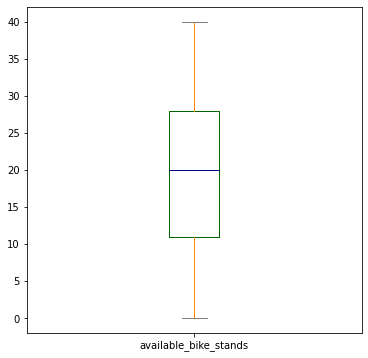

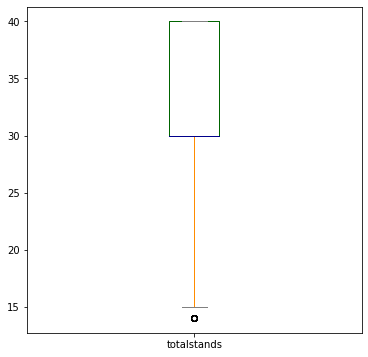

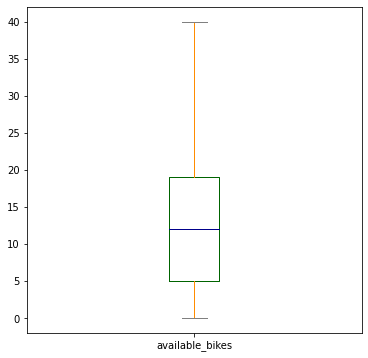

In [19]:
bike_box = {'available_bikes','available_bike_stands', 'totalstands'}
color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange', 'medians': 'DarkBlue', 'caps': 'Gray'}

for col in bike_box:
    f = df_bikes[col].plot(color= color, kind='box', figsize=(6, 6))
    plt.show()

C:\Users\XING\AppData\Local\Temp\ipykernel_75136\2751104968.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_bikes[bike_box].hist(figsize=(10, 10))


array([[<AxesSubplot:title={'center':'available_bike_stands'}>,
        <AxesSubplot:title={'center':'totalstands'}>],
       [<AxesSubplot:title={'center':'available_bikes'}>, <AxesSubplot:>]],
      dtype=object)

<Figure size 432x288 with 0 Axes>

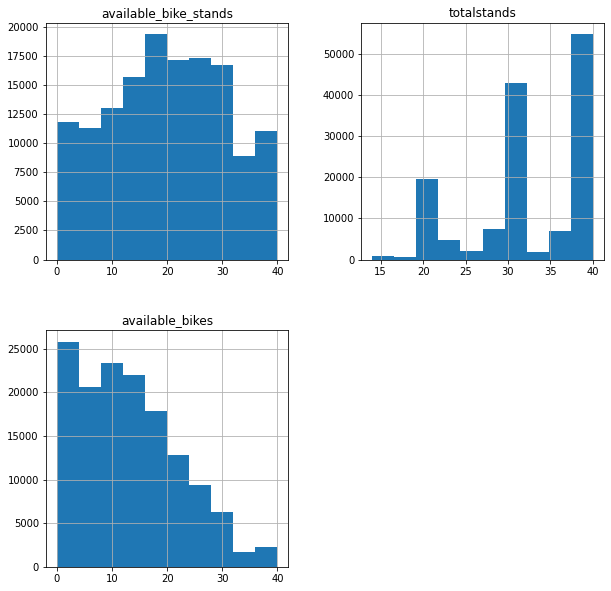

In [20]:
plt.figure()
df_bikes[bike_box].hist(figsize=(10, 10))

<AxesSubplot:xlabel='available_bikes', ylabel='available_bike_stands'>

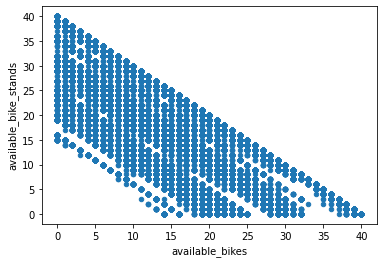

In [21]:
# the total number of the available bikes and available bike stands are fixed
df_bikes.plot(kind='scatter', x='available_bikes', y='available_bike_stands')

<AxesSubplot:>

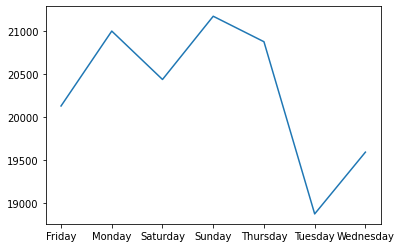

In [22]:
df_bikes.weekday.value_counts().sort_index().plot()

## store the fixed station stands

In [23]:
df_station = pd.DataFrame(df_bikes, columns=['number', 'totalstands'])
df_station = df_station.drop_duplicates(['number'])
df_station = df_station.reset_index().drop('index',axis=1)
df_station

,number,totalstands
0,2,20
1,3,20
2,4,20
3,5,40
4,6,20
...,...,...
105,113,40
106,114,40
107,115,30
108,116,30


In [24]:
df_station['totalstands'][df_bikes['number'] == 2].iloc[0]

20

In [25]:
station_total_stands = dict()
for ID in df_station['number']:
    station_total_stands[ID] = df_station['totalstands'][df_station['number'] == ID].iloc[0]
    #featimp = pd.Series(models[ID].feature_importances_, index=modelfeatures).sort_values(ascending=False)
print(station_total_stands)

{2: 20, 3: 20, 4: 20, 5: 40, 6: 20, 7: 29, 8: 30, 9: 24, 10: 16, 11: 30, 12: 20, 13: 30, 15: 16, 16: 20, 17: 20, 18: 30, 19: 30, 21: 30, 22: 20, 23: 30, 24: 20, 25: 29, 26: 20, 27: 20, 28: 30, 29: 29, 30: 20, 31: 20, 32: 30, 33: 23, 34: 30, 36: 40, 37: 30, 38: 40, 39: 20, 40: 21, 41: 20, 42: 30, 43: 30, 44: 30, 45: 30, 47: 40, 48: 40, 49: 40, 50: 40, 51: 40, 52: 32, 53: 40, 54: 33, 55: 36, 56: 40, 57: 23, 58: 39, 59: 20, 60: 30, 61: 25, 62: 40, 63: 35, 64: 40, 65: 40, 66: 40, 67: 40, 68: 40, 69: 40, 71: 40, 72: 31, 73: 30, 74: 30, 75: 40, 76: 38, 77: 29, 78: 40, 79: 27, 80: 40, 82: 22, 83: 40, 84: 30, 85: 35, 86: 38, 87: 38, 88: 30, 89: 40, 90: 39, 91: 30, 92: 40, 93: 40, 94: 40, 95: 40, 96: 30, 97: 40, 98: 40, 99: 30, 100: 25, 101: 30, 102: 40, 103: 40, 104: 40, 105: 36, 106: 40, 107: 40, 108: 35, 109: 29, 110: 40, 111: 40, 112: 30, 113: 40, 114: 40, 115: 30, 116: 30, 117: 40}


In [26]:
df_station.describe().T

,count,mean,std,min,25%,50%,75%,max
number,110.0,60.327273,33.864844,2.0,31.25,60.5,89.75,117.0
totalstands,110.0,32.018182,7.603695,16.0,29.00,30.0,40.00,40.0


In [27]:
len(station_total_stands)

110

## save as csv

In [28]:
df_bikes.to_csv('df_bikes.csv',index=None)

In [29]:
df_station.to_csv('df_station.csv',index=None)

# weather data

In [30]:
df_weather = pd.read_sql_table("weather_Dublin",engine)

2022-04-14 19:40:01,301 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-14 19:40:01,302 INFO sqlalchemy.engine.Engine [cached since 6.792s ago] {'table_schema': 'dbbikes1', 'table_name': 'weather_Dublin'}
2022-04-14 19:40:01,680 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `weather_Dublin`
2022-04-14 19:40:01,681 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-14 19:40:01,969 INFO sqlalchemy.engine.Engine SELECT `weather_Dublin`.`Clouds`, `weather_Dublin`.feels_like, `weather_Dublin`.humidity, `weather_Dublin`.pressure, `weather_Dublin`.temp, `weather_Dublin`.temp_max, `weather_Dublin`.temp_min, `weather_Dublin`.sunrise, `weather_Dublin`.sunset, `weather_Dublin`.visibility, `weather_Dublin`.weather_description, `weather_Dublin`.weather_main, `weather_Dublin`.wind_deg, `weather_Dublin`.wind_speed, `weather_Dublin`.dt 
FROM `weather_Dublin`
2022-04-14 19:40:01,970 INFO sqlalch

In [31]:
df_weather.shape

(4134, 15)

In [32]:
df_weather.tail()

,Clouds,feels_like,humidity,pressure,temp,temp_max,temp_min,sunrise,sunset,visibility,weather_description,weather_main,wind_deg,wind_speed,dt
4129,40,280.20,89,1017,280.91,283.71,277.51,2022-04-14 05:27:58,2022-04-14 19:22:21,10000,scattered clouds,Clouds,230,1.54,2022-04-14 01:17:09
4130,75,281.98,90,1019,282.88,284.14,281.97,2022-04-14 05:27:58,2022-04-14 19:22:21,10000,broken clouds,Clouds,170,2.06,2022-04-14 07:46:37
4131,75,282.03,90,1019,282.92,284.14,282.36,2022-04-14 05:27:58,2022-04-14 19:22:21,10000,broken clouds,Clouds,170,2.06,2022-04-14 07:51:37
4132,75,287.57,70,1019,288.18,288.71,286.47,2022-04-14 05:27:58,2022-04-14 19:22:21,10000,broken clouds,Clouds,190,5.66,2022-04-14 11:56:13
4133,75,287.54,70,1019,288.16,288.64,286.47,2022-04-14 05:27:58,2022-04-14 19:22:21,10000,broken clouds,Clouds,190,5.66,2022-04-14 12:00:38


In [33]:
df_weather.dtypes

Clouds                   int64
feels_like             float64
humidity                 int64
pressure                 int64
temp                   float64
temp_max               float64
temp_min               float64
sunrise                 object
sunset                  object
visibility               int64
weather_description     object
weather_main            object
wind_deg                 int64
wind_speed             float64
dt                      object
dtype: object

## change datatype and add new features 

In [34]:
datetime_columns = ['sunrise', 'sunset', 'dt']
for column in datetime_columns:
    df_weather[column] = df_weather[column].astype('datetime64[ns]')
    
categorical_columns = ['weather_description','weather_main']
for column in categorical_columns:
    df_weather[column] = df_weather[column].astype('category')


In [35]:
df_weather.dtypes

Clouds                          int64
feels_like                    float64
humidity                        int64
pressure                        int64
temp                          float64
temp_max                      float64
temp_min                      float64
sunrise                datetime64[ns]
sunset                 datetime64[ns]
visibility                      int64
weather_description          category
weather_main                 category
wind_deg                        int64
wind_speed                    float64
dt                     datetime64[ns]
dtype: object

At first, I think the daytime(sunrise and sunset hour) will affect the use of bikes.  
However our data ranges from March to April, and the difference won't be too much, so I will drop this attribute in analysis.  

In [36]:
#df_weather['weekday'] = df_weather.dt.dt.day_name()
df_weather['date'] = df_weather.dt.dt.date
df_weather['hour'] = df_weather.dt.dt.hour
df_weather['minute'] = df_weather.dt.dt.minute
df_weather['sunrise_hour'] = df_weather.sunrise.dt.hour
df_weather['sunset_hour'] = df_weather.sunset.dt.hour
#df_weather['weekday'] = df_weather['weekday'].astype('category')

In [37]:
#df_weather['id'] = range(len(df_weather))
df_weather = df_weather[['dt','date','hour','minute','sunrise','sunset','sunrise_hour','sunset_hour','weather_main','weather_description','temp','feels_like','humidity','pressure','temp_max','temp_min','Clouds','visibility','wind_deg','wind_speed']]
df_weather.head()

,dt,date,hour,minute,sunrise,sunset,sunrise_hour,sunset_hour,weather_main,weather_description,temp,feels_like,humidity,pressure,temp_max,temp_min,Clouds,visibility,wind_deg,wind_speed
0,2022-03-30 16:58:29,2022-03-30,16,58,2022-03-30 06:03:36,2022-03-30 18:55:16,6,18,Clouds,broken clouds,279.49,275.15,73,1009,280.03,279.03,75,10000,40,7.72
1,2022-03-30 17:04:30,2022-03-30,17,4,2022-03-30 06:03:36,2022-03-30 18:55:16,6,18,Clouds,broken clouds,279.40,275.03,73,1009,279.82,278.69,75,10000,40,7.72
2,2022-03-30 17:07:46,2022-03-30,17,7,2022-03-30 06:03:36,2022-03-30 18:55:16,6,18,Clouds,broken clouds,279.40,275.03,73,1009,279.82,278.69,75,10000,40,7.72
3,2022-03-30 17:16:07,2022-03-30,17,16,2022-03-30 06:03:36,2022-03-30 18:55:16,6,18,Clouds,broken clouds,279.43,275.07,71,1009,279.82,279.03,75,10000,30,7.72
4,2022-03-30 17:07:46,2022-03-30,17,7,2022-03-30 06:03:36,2022-03-30 18:55:16,6,18,Clouds,broken clouds,279.40,275.03,73,1009,279.82,278.69,75,10000,40,7.72


In [38]:
df_weather.dtypes

dt                     datetime64[ns]
date                           object
hour                            int64
minute                          int64
sunrise                datetime64[ns]
sunset                 datetime64[ns]
sunrise_hour                    int64
sunset_hour                     int64
weather_main                 category
weather_description          category
temp                          float64
feels_like                    float64
humidity                        int64
pressure                        int64
temp_max                      float64
temp_min                      float64
Clouds                          int64
visibility                      int64
wind_deg                        int64
wind_speed                    float64
dtype: object

## check null, duplicate and corrupt data

In [39]:
#check null value
df_weather[df_weather.isnull().values==True]

,dt,date,hour,minute,sunrise,sunset,sunrise_hour,sunset_hour,weather_main,weather_description,temp,feels_like,humidity,pressure,temp_max,temp_min,Clouds,visibility,wind_deg,wind_speed


In [40]:
# include first row
include_duplicate = df_weather[df_weather.duplicated(keep=False)].shape[0]
print("There are {} duplicate rows including the first row.".format(include_duplicate))

There are 2405 duplicate rows including the first row.


In [41]:
df_weather[df_weather.duplicated(keep=False)]

,dt,date,hour,minute,sunrise,sunset,sunrise_hour,sunset_hour,weather_main,weather_description,temp,feels_like,humidity,pressure,temp_max,temp_min,Clouds,visibility,wind_deg,wind_speed
2,2022-03-30 17:07:46,2022-03-30,17,7,2022-03-30 06:03:36,2022-03-30 18:55:16,6,18,Clouds,broken clouds,279.40,275.03,73,1009,279.82,278.69,75,10000,40,7.72
4,2022-03-30 17:07:46,2022-03-30,17,7,2022-03-30 06:03:36,2022-03-30 18:55:16,6,18,Clouds,broken clouds,279.40,275.03,73,1009,279.82,278.69,75,10000,40,7.72
6,2022-03-30 17:30:31,2022-03-30,17,30,2022-03-30 06:03:36,2022-03-30 18:55:16,6,18,Clouds,broken clouds,279.48,275.14,70,1009,279.83,278.64,75,10000,30,7.72
7,2022-03-30 17:30:31,2022-03-30,17,30,2022-03-30 06:03:36,2022-03-30 18:55:16,6,18,Clouds,broken clouds,279.48,275.14,70,1009,279.83,278.64,75,10000,30,7.72
8,2022-03-30 17:30:31,2022-03-30,17,30,2022-03-30 06:03:36,2022-03-30 18:55:16,6,18,Clouds,broken clouds,279.48,275.14,70,1009,279.83,278.64,75,10000,30,7.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4123,2022-04-14 00:40:30,2022-04-14,0,40,2022-04-14 05:27:58,2022-04-14 19:22:21,5,19,Clouds,broken clouds,282.03,281.48,86,1017,284.26,278.51,75,10000,130,1.54
4125,2022-04-14 00:52:11,2022-04-14,0,52,2022-04-14 05:27:58,2022-04-14 19:22:21,5,19,Clouds,broken clouds,282.03,281.48,87,1018,284.26,278.51,75,10000,130,1.54
4126,2022-04-14 01:00:06,2022-04-14,1,0,2022-04-14 05:27:58,2022-04-14 19:22:21,5,19,Clouds,broken clouds,281.85,281.85,88,1018,284.26,278.51,75,10000,0,0.51
4127,2022-04-14 00:52:11,2022-04-14,0,52,2022-04-14 05:27:58,2022-04-14 19:22:21,5,19,Clouds,broken clouds,282.03,281.48,87,1018,284.26,278.51,75,10000,130,1.54


In [42]:
df_weather = df_weather.drop_duplicates(keep=False)
#df_weather[df_weather.duplicated(keep=False)]
#check duplicated rows after dropping
# include first row
include_duplicate = df_weather[df_weather.duplicated(keep=False)].shape[0]
print("There are {} duplicate rows including the first row.".format(include_duplicate))

There are 0 duplicate rows including the first row.


## plot

In [43]:
df_weather.select_dtypes(['category']).describe().T

,count,unique,top,freq
weather_main,1729,5,Clouds,1449
weather_description,1729,12,broken clouds,858


In [44]:
numeric_weather= df_weather.select_dtypes(['int64']).columns
df_weather[numeric_weather].describe().T

,count,mean,std,min,25%,50%,75%,max
hour,1729.0,11.580104,7.021180,0.0,6.0,11.0,18.0,23.0
minute,1729.0,29.074610,17.338664,0.0,15.0,30.0,45.0,59.0
sunrise_hour,1729.0,5.089069,0.284925,5.0,5.0,5.0,5.0,6.0
sunset_hour,1729.0,18.840949,0.365830,18.0,19.0,19.0,19.0,19.0
humidity,1729.0,77.402545,11.326433,46.0,71.0,79.0,86.0,95.0
pressure,1729.0,1010.423366,11.648103,980.0,1002.0,1013.0,1019.0,1028.0
Clouds,1729.0,57.237710,25.655225,0.0,40.0,75.0,75.0,100.0
visibility,1729.0,9608.964719,1346.774921,2500.0,10000.0,10000.0,10000.0,10000.0
wind_deg,1729.0,216.628687,95.495539,0.0,150.0,250.0,280.0,360.0


<AxesSubplot:>

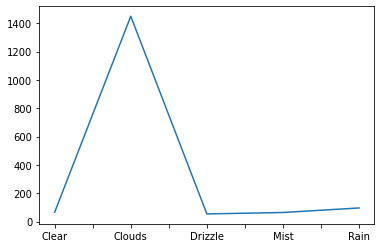

In [45]:
df_weather.weather_main.value_counts().sort_index().plot()

<AxesSubplot:>

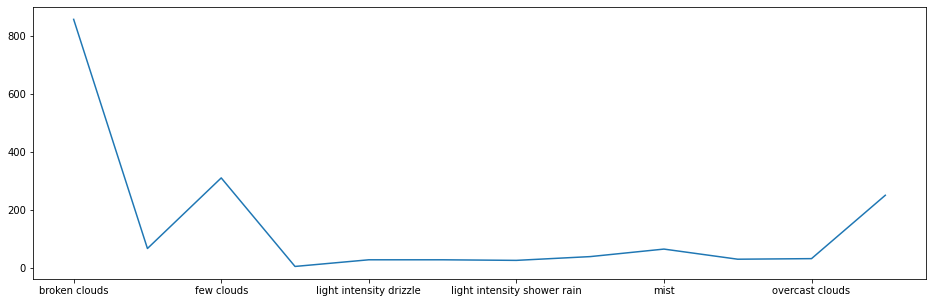

In [46]:
df_weather.weather_description.value_counts().sort_index().plot(figsize=(16, 5))

## save as csv

In [47]:
df_weather.to_csv('df_weather.csv',index=None)

## three ways of merge 
here I was considering three ways to merge the bikes availability and weather data  
first is **date-hour-minute**  
second is **date-hour**  
last is use **merge_asof** function.  
This is similar to a left-join except that we match on nearest key rather than equal keys. Both DataFrames must be sorted by the key.  
However there would be some NULL columns after merging, the we need to drop the rows that contain NULL values. I think it would affect the accuarcy of the analysis.

In [48]:
#df = pd.merge(df_bikes, df_weather, on = ['date', 'hour','minute'], how = 'inner')

In [49]:
df_bikes_sorted = df_bikes.sort_values(by=['last_update'])
df_weather_sorted = df_weather.sort_values(by=['dt'])
df = pd.merge_asof(df_bikes_sorted,df_weather_sorted, left_on='last_update', right_on='dt')

## check null, duplicate and corrupt data
here are some null values appear in weather part, because bike scraper starts earlier than weather scraper, delete them

In [50]:
df[df.isnull().values==True]

,number,weekday,available_bike_stands,available_bikes,totalstands,date_x,hour_x,minute_x,last_update,status,dt,date_y,hour_y,minute_y,sunrise,sunset,sunrise_hour,sunset_hour,weather_main,weather_description,temp,feels_like,humidity,pressure,temp_max,temp_min,Clouds,visibility,wind_deg,wind_speed
0,65,Wednesday,27,13,40,2022-03-30,12.0,48.0,2022-03-30 12:48:22,OPEN,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,65,Wednesday,27,13,40,2022-03-30,12.0,48.0,2022-03-30 12:48:22,OPEN,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,65,Wednesday,27,13,40,2022-03-30,12.0,48.0,2022-03-30 12:48:22,OPEN,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,65,Wednesday,27,13,40,2022-03-30,12.0,48.0,2022-03-30 12:48:22,OPEN,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,65,Wednesday,27,13,40,2022-03-30,12.0,48.0,2022-03-30 12:48:22,OPEN,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,112,Wednesday,20,10,30,2022-03-30,16.0,17.0,2022-03-30 16:17:23,OPEN,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
659,112,Wednesday,20,10,30,2022-03-30,16.0,17.0,2022-03-30 16:17:23,OPEN,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
659,112,Wednesday,20,10,30,2022-03-30,16.0,17.0,2022-03-30 16:17:23,OPEN,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
659,112,Wednesday,20,10,30,2022-03-30,16.0,17.0,2022-03-30 16:17:23,OPEN,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
df.dropna(axis=0, how='any',inplace=True)

I think the hour of sunrise and sunset matters.   
However the time peroid of scrapping data is only two weeks, I don't think it will affect too much, that's why I delete them.

In [52]:
# drop the exact time of weather after merging, just keep the time of scrapping bikes
# drop the temp_max, temp_min, feels_like because they are kind of repeated
# drop the wind deg and weather_description because of lacking varieties
# drop status because is a constant
df = df.drop(columns=['totalstands','status','dt','date_y','hour_y','minute_y','sunrise','sunset','sunrise_hour','sunset_hour','temp_max','temp_min','feels_like','wind_deg','weather_description'])

In [53]:
df.dtypes

number                            int64
weekday                        category
available_bike_stands             int64
available_bikes                   int64
date_x                           object
hour_x                          float64
minute_x                        float64
last_update              datetime64[ns]
weather_main                   category
temp                            float64
humidity                        float64
pressure                        float64
Clouds                          float64
visibility                      float64
wind_speed                      float64
dtype: object

## save as csv

In [54]:
df.to_csv('df_merged.csv',index=None)

## Dummy encoding

In [55]:
df.dtypes

number                            int64
weekday                        category
available_bike_stands             int64
available_bikes                   int64
date_x                           object
hour_x                          float64
minute_x                        float64
last_update              datetime64[ns]
weather_main                   category
temp                            float64
humidity                        float64
pressure                        float64
Clouds                          float64
visibility                      float64
wind_speed                      float64
dtype: object

In [56]:
df['date_x'] = df['date_x'].astype('datetime64[ns]')

In [57]:
#df.shape
#df[df.isnull().values==True]

In [58]:
features = df.columns.values.tolist()
features

['number',
 'weekday',
 'available_bike_stands',
 'available_bikes',
 'date_x',
 'hour_x',
 'minute_x',
 'last_update',
 'weather_main',
 'temp',
 'humidity',
 'pressure',
 'Clouds',
 'visibility',
 'wind_speed']

## store data by station numbers
use a dictionary `station_dfs`, to store the data of df, key is a station number, and values are a new sliced dataframe df_model

In [59]:
# drop the last_update
# drop number because it's already the key of dictionary
# drop the status because it's a constant variable 
# set dummies code for the category columns
station_dfs = dict()
for ID in df['number'].unique():
    df_model = df[df['number']==ID].copy().drop('last_update',axis=1)
    df_model = df_model.drop('number',axis=1)
    #https://zhuanlan.zhihu.com/p/109913870
    df_model = df_model.reset_index().drop('index',axis=1)
    df_model = pd.get_dummies(df_model,drop_first=False)
    station_dfs[ID] = df_model


## model training

use a dictionary `models` to store, the key is station number and values are training models  
`modelfeatures` to store the features we need to input  
we use `RandomForest` to predict  

In [60]:
models = dict()
#scores = dict()
modelfeatures = ['hour_x',
       'minute_x', 'temp', 'humidity', 'pressure', 'Clouds', 'visibility',
       'wind_speed', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'weather_main_Clear', 'weather_main_Clouds',
       'weather_main_Drizzle', 'weather_main_Rain']

for ID in station_dfs:
    input_model = station_dfs[ID][modelfeatures]
    output = station_dfs[ID]['available_bikes']
    # it has a warnning, solution: https://stackoverflow.com/questions/69326639/sklearn-warning-valid-feature-names-in-version-1-0
    print("=======Start with the station: %s =======" % ID)
    X_train,X_test,Y_train,Y_test=train_test_split(input_model.values,output.values,test_size=0.33,random_state=0)
    print("Training the model on %s rows and %s columns." % X_train.shape)
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, Y_train)
    print("Testing the model on %s rows." % Y_test.shape[0])
    
    models[ID] = rf.fit(X_train, Y_train)
    #scores[ID] = rf.score(X_test,Y_test)

=======Start with the station: 79 =======
Training the model on 959 rows and 19 columns.
Testing the model on 473 rows.
=======Start with the station: 61 =======
Training the model on 1030 rows and 19 columns.
Testing the model on 508 rows.
=======Start with the station: 113 =======
Training the model on 1070 rows and 19 columns.
Testing the model on 528 rows.
=======Start with the station: 36 =======
Training the model on 938 rows and 19 columns.
Testing the model on 463 rows.
=======Start with the station: 41 =======
Training the model on 312 rows and 19 columns.
Testing the model on 155 rows.
=======Start with the station: 109 =======
Training the model on 316 rows and 19 columns.
Testing the model on 157 rows.
=======Start with the station: 67 =======
Training the model on 1060 rows and 19 columns.
Testing the model on 523 rows.
=======Start with the station: 116 =======
Training the model on 1055 rows and 19 columns.
Testing the model on 521 rows.
=======Start with the station: 49

=======Start with the station: 5 =======
Training the model on 1045 rows and 19 columns.
Testing the model on 516 rows.
=======Start with the station: 48 =======
Training the model on 1152 rows and 19 columns.
Testing the model on 568 rows.
=======Start with the station: 19 =======
Training the model on 1017 rows and 19 columns.
Testing the model on 501 rows.
=======Start with the station: 101 =======
Training the model on 990 rows and 19 columns.
Testing the model on 488 rows.
=======Start with the station: 66 =======
Training the model on 994 rows and 19 columns.
Testing the model on 491 rows.
=======Start with the station: 75 =======
Training the model on 912 rows and 19 columns.
Testing the model on 450 rows.
=======Start with the station: 63 =======
Training the model on 1076 rows and 19 columns.
Testing the model on 530 rows.
=======Start with the station: 16 =======
Training the model on 972 rows and 19 columns.
Testing the model on 480 rows.
=======Start with the station: 9 ===

In [61]:
input_model.head()

,hour_x,minute_x,temp,humidity,pressure,Clouds,visibility,wind_speed,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Rain
0,19.0,54.0,276.31,86.0,1012.0,40.0,10000.0,6.69,0,0,0,0,0,0,1,0,0,0,1
1,19.0,54.0,276.31,86.0,1012.0,40.0,10000.0,6.69,0,0,0,0,0,0,1,0,0,0,1
2,20.0,5.0,276.31,86.0,1012.0,40.0,10000.0,6.69,0,0,0,0,0,0,1,0,0,0,1
3,20.0,17.0,276.43,86.0,1012.0,40.0,10000.0,4.12,0,0,0,0,0,0,1,0,1,0,0
4,20.0,27.0,276.59,84.0,1012.0,75.0,10000.0,6.17,0,0,0,0,0,0,1,0,1,0,0


## Model Test

In [62]:
for ID in station_dfs:
    x = station_dfs[ID][modelfeatures]  
    y = station_dfs[ID]['available_bikes']
    # ForestRegressor.predict()
    prediction = models[ID].predict(x.values)
    
    print("\nPredictions with Random Forest regression: \n")
    actual_vs_predicted = pd.concat([y, pd.DataFrame(prediction, columns=['Predicted'])], axis=1)
    print(actual_vs_predicted)
    


Predictions with Random Forest regression: 

      available_bikes  Predicted
0                   8       8.52
1                   7       9.64
2                   8      10.02
3                   8       8.05
4                   8       8.16
...               ...        ...
1427               14      13.74
1428               14      13.30
1429               13      12.66
1430               12      12.61
1431               12      13.01

[1432 rows x 2 columns]

Predictions with Random Forest regression: 

      available_bikes  Predicted
0                   0       1.42
1                   0       1.17
2                   0       1.14
3                   0       1.27
4                   0       1.18
...               ...        ...
1533                2       1.30
1534                2       0.76
1535                1       0.76
1536                1       1.12
1537                0       0.82

[1538 rows x 2 columns]

Predictions with Random Forest regression: 

      available_bike

[1392 rows x 2 columns]

Predictions with Random Forest regression: 

      available_bikes  Predicted
0                   3       5.10
1                   3       5.20
2                   2       5.13
3                   2       5.80
4                   1       7.00
...               ...        ...
1735               19      18.77
1736               19      18.57
1737               19      17.50
1738               21      20.48
1739               18      19.87

[1740 rows x 2 columns]

Predictions with Random Forest regression: 

      available_bikes  Predicted
0                   7       7.01
1                   5       6.91
2                   5       6.66
3                   5       5.42
4                   5       5.45
...               ...        ...
2061                4       2.27
2062                3       2.75
2063                2       1.42
2064                2       0.69
2065                0       0.51

[2066 rows x 2 columns]

Predictions with Random Forest regression


Predictions with Random Forest regression: 

      available_bikes  Predicted
0                  27      26.55
1                  27      26.02
2                  27      26.50
3                  27      27.49
4                  27      27.55
...               ...        ...
1468               17      17.17
1469               17      16.98
1470               16      16.31
1471               17      16.87
1472               17      17.33

[1473 rows x 2 columns]

Predictions with Random Forest regression: 

     available_bikes  Predicted
0                 25      24.55
1                 26      24.64
2                 26      25.30
3                 26      24.20
4                 27      24.20
..               ...        ...
458               15      14.84
459               16      15.12
460               16      15.24
461               14      14.21
462               16      13.79

[463 rows x 2 columns]

Predictions with Random Forest regression: 

      available_bikes  Predicted


[1561 rows x 2 columns]

Predictions with Random Forest regression: 

      available_bikes  Predicted
0                   7       6.86
1                   7       6.88
2                   5       6.69
3                   5       5.79
4                   5       7.41
...               ...        ...
1715               20      17.15
1716               22      18.24
1717               20      19.44
1718               21      23.21
1719               19      23.53

[1720 rows x 2 columns]

Predictions with Random Forest regression: 

      available_bikes  Predicted
0                   0       0.44
1                   1       0.42
2                   0       1.14
3                   1       1.08
4                   0       1.05
...               ...        ...
1513                0       1.26
1514                1       2.13
1515                3       2.71
1516                3       3.05
1517                2       2.21

[1518 rows x 2 columns]

Predictions with Random Forest regression

[1634 rows x 2 columns]

Predictions with Random Forest regression: 

      available_bikes  Predicted
0                   3       4.34
1                   4       4.77
2                   5       4.73
3                   5       4.86
4                   4       4.93
...               ...        ...
1671               16      15.16
1672               16      15.27
1673               12      12.78
1674               13      13.14
1675               13      13.47

[1676 rows x 2 columns]

Predictions with Random Forest regression: 

      available_bikes  Predicted
0                  25      23.50
1                  24      23.50
2                  26      26.84
3                  27      27.54
4                  29      27.67
...               ...        ...
1676                8       5.04
1677                8       7.07
1678                8       7.22
1679                5       5.88
1680                4       5.78

[1681 rows x 2 columns]

Predictions with Random Forest regression

## Model Evaluation

### Four Loss Function
### MAE
Mean Absolute Error  
Prediction Error → Actual Value - Predicted Value  
Absolute Error → |Prediction Error|  
MAE = Average of All absolute errors  
### MSE
Mean Squared Error  
Prediction Error → Actual Value - Predicted Value  
Squared Error → (Prediction Error)^2  
MSE = Average of All Squared errors 
smaller and better
### RMSE
Root mean square error  
RMSE = root of MSE  
smaller and better
### R^2
R-squared = 1 - ourModelError / baselineModelError  
ourModelError  = MSE  
baselineModelError = variance  
range from [0,1], the closer to 1, the better
### calculate loss function
sklearn.metrics is a package of function to calculate the loss, we input the real results and the prediction results and it will return the loss

In [63]:
def modelEvalucation(actualVal, predictions):
    #classification evaluation measures
    print("MAE: ", metrics.mean_absolute_error(actualVal, predictions))
    print("MSE: ", metrics.mean_squared_error(actualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(actualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(actualVal, predictions))
    print("\n")

In [64]:
RMSEs = []
R2 = []
X_train_size_avg = 0
X_test_size_avg = 0

for ID in station_dfs:
    X = station_dfs[ID][modelfeatures]
    Y = station_dfs[ID]['available_bikes']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    
    #add to avg size of train/test arrays
    X_train_size_avg += X_train.shape[0]/len(station_dfs)
    X_test_size_avg += X_test.shape[0]/len(station_dfs)
    #model = RandomForestRegression().fit(X_train.values,y_train.values)
    prediction = models[ID].predict(X_test.values)
    #actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(prediction, columns=['Predicted'])], axis=1)
    print("=======Start with the station: %s =======\n" % ID)
    modelEvalucation(y_test, prediction)
    
    RMSEs += [metrics.mean_squared_error(y_test, prediction)**0.5]
    R2 += [metrics.r2_score(y_test, prediction)]


=======Start with the station: 79 =======

MAE:  0.5720019379844962
MSE:  1.40846943003876
RMSE:  1.1867895474930505
R2:  0.9390015052255392


=======Start with the station: 61 =======

MAE:  0.5760649350649351
MSE:  1.6720437436267435
RMSE:  1.2930753047006749
R2:  0.9001555196918712


=======Start with the station: 113 =======

MAE:  0.7573194444444444
MSE:  2.096844523842593
RMSE:  1.448048522613311
R2:  0.9614518622580357


=======Start with the station: 36 =======

MAE:  1.1133202692003168
MSE:  3.9691644211533386
RMSE:  1.9922761909818976
R2:  0.9474944646172001


=======Start with the station: 41 =======

MAE:  0.6130496453900709
MSE:  1.243182978723404
RMSE:  1.1149811562189758
R2:  0.9195755482955654


=======Start with the station: 109 =======

MAE:  0.8316561032863851
MSE:  3.4734943898669806
RMSE:  1.863731308388358
R2:  0.9105662038178447


=======Start with the station: 67 =======

MAE:  1.3653684210526318
MSE:  5.228793473684211
RMSE:  2.2866555214295423
R2:  0.937456394

MAE:  0.5690226876090749
MSE:  0.7958514834205933
RMSE:  0.8921050854134804
R2:  0.9875143671746525


=======Start with the station: 76 =======

MAE:  1.1143310238645112
MSE:  4.283981867077239
RMSE:  2.069778216881519
R2:  0.9284174984148419


=======Start with the station: 55 =======

MAE:  0.49375796178343945
MSE:  1.5219154989384294
RMSE:  1.2336593934058255
R2:  0.9416819897162858


=======Start with the station: 43 =======

MAE:  1.3842887369791668
MSE:  5.1932181437174485
RMSE:  2.2788633446780984
R2:  0.9439399601605876


=======Start with the station: 53 =======

MAE:  0.7099552572706934
MSE:  2.0009872483221476
RMSE:  1.4145625643011155
R2:  0.9646166906292856


=======Start with the station: 26 =======

MAE:  0.6842758620689655
MSE:  1.4431558620689655
RMSE:  1.2013142228696727
R2:  0.9347700748129676


=======Start with the station: 98 =======

MAE:  0.7861100196463654
MSE:  1.8849597249508838
RMSE:  1.3729383543884568
R2:  0.986221462529057


=======Start with the station:

In [67]:
print('Avgerage train/test size: %.0f/%.0f'%(X_train_size_avg,X_test_size_avg))
print("The minimum RMSE of all predition models is: %f" %min(RMSEs))
print("The maximum RMSE of all predition models is: %f" %max(RMSEs))
print("The minimum R2 of all predition models is: %f" %min(R2))
print("The maximum R2 of all predition models is: %f" %max(R2))

Avgerage train/test size: 899/386
The minimum RMSE of all predition models is: 0.632750
The maximum RMSE of all predition models is: 3.615871
The minimum R2 of all predition models is: 0.636479
The maximum R2 of all predition models is: 0.987514


## export and generate pickcle file

In [66]:
import pickle

for ID in models:
    with open('model_'+str(ID)+'.pkl','wb') as handle:
        pickle.dump(models[ID], handle, pickle.HIGHEST_PROTOCOL)